# Applying the Angiuli-Fouque-Lauriere Unified Two Timescale Mean Field Q-Learning Algorithm for Finite-Horizon Problems
## By: James Chen
## Mentored by: Professor Aaron Palmer & Wonjun Lee
## Adapted from: Farez Siddiqui

<br>
This mini-project was my attempt to learn more about mean field game (MFG)/mean field control (MFC) problems, and to attempt to engage with a new numerical method utilizing machine learning to solve such problems that was recently proposed by Andrea Angiuli, Jean-Pierre Fouque, and Mathieu Lauriere in their 2021 paper:

__[Unified Reinforcement Q-Learning for Mean Field Game and Control Problems](https://arxiv.org/abs/2006.13912)__

# Following transition rate in trader execution problem related to volatility?

In [4]:
import math
import numpy as np
from numpy import random as rnd
from scipy.linalg import expm
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [21]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def update_X_prime(x, alpha):
    proposed = state_space[x] + action_space[alpha]*dt + sigma*rnd.randn()*np.sqrt(dt)
    X_prime = find_nearest(state_space, proposed)
    return X_prime

def initialize_X():
    return find_nearest(state_space, rnd.randn()*.3 + .5)

In [58]:
T        = 1
N_s      = 2

# time-step length
dt = T/N_s

# state space & action space
state_space  = np.arange(-1.5, 1.75, 1/4)
action_space = np.arange(-2.5, 1, 1/4)

# cardinality of state & action spaces
d        = len(state_space)
m        = len(action_space)

# parameters
c_alpha  = 1
c_x      = 2
c_g      = .3

# variance
sigma    = .5

# exploration rate for e-greedy
epsilon  = .1

# discount factor/weight on future costs
gamma    = 1.75

# controls learning rate for Q
omega_Q  = .55

# controls learning rate for state distribution
omega_nu = .85

# cost
def f(x, alpha, nu):
    return ((c_alpha/2)*action_space[alpha]**2 + (c_x/2)*state_space[x]**2
            - gamma*state_space[x]*action_space@np.sum(nu, axis = 0))
                                    # inner product for integral

# array to hold actions
actions = np.zeros(episodes)

In [73]:
#utilize previous Q table for efficiency
def RL(episodes):
    '''
    Angiuli-Fouque-Lauriere Unified Two Timescale Mean Field Q-Learning algorithm for finite horizon
    Specifically written for the Botnet defense problem by Kolokoltsov & Bensoussan
    '''

    # store action arrays
    actions = np.zeros((episodes, N_s+1))

    # initialize state distribution flow
    nu      = (1/(d*m))*np.ones((N_s+1, d, m)) # uniform dist for all state-action pairs
    
    # initialize Q table
    Q       = np.zeros((N_s+1, d, m))          # will be updated but not stored
    
    # counter for each time state-action pair is visited for use in calculating learning rate for Q
    sa_counter = np.zeros((N_s+1, d, m))

    # matrix that when sliced on state index will serve as dirac delta for that state for updating distribution
    dirac = np.diag(np.ones((d*m)))
    
    # loop through episodes
    for k in tqdm(range(episodes)):
        
        # calculate state distribution learning rate for episode
        rho_nu = 1/(1 + (k+1))**omega_nu
        
        # randomly select starting state based on initial distribution
        X = initialize_X()
        
        # simulate episode
        for tau in range(N_s+1):
            
            # give optimal action for given Q table
            min_A = np.argmin(Q[tau, X])
            
            # use epsilon-greedy criterion for action selection
            if rnd.uniform() > epsilon:
                A = min_A
            else:
                A = rnd.choice(range(m))
            
            # increment counter for state-action visits by 1 for calculating learning rate for Q
            sa_counter[tau, X, A] += 1

            # update distribution
            nu[tau] = nu[tau] + rho_nu*(dirac[X*m+A].reshape(d,m) - nu[tau])

            # calculate learning rate for Q (notice the N_s for finite horizon)
            rho_Q = 1/(1 + N_s*sa_counter[tau, X, A])**omega_Q

            # observe next state
            X_prime = update_X_prime(X, A)
            
            # update Q table
            if tau == N_s:
                B = (c_g/2)*state_space[X_prime]**2 # Almgren-Chriss framework
            else:
                B = f(X_prime, A, nu[tau]) + gamma*np.min(Q[tau+1, X_prime])
            Q[tau, X, A] = Q[tau, X, A] + rho_Q*(B - Q[tau, X, A])

            # set next state for following time-step
            X = X_prime

            if tau == 0:
                actions[k, tau] = np.mean([action_space[np.argmin(Q[tau,n])] for n in range(d)])
            if tau == 1:
                actions[k, tau] = np.mean([action_space[np.argmin(Q[tau,n])] for n in range(d)])
            if tau == 2:
                actions[k, tau] = np.mean([action_space[np.argmin(Q[tau,n])] for n in range(d)])

    # closes tqdm instances so progress bar does not print to a new line with each iteration upon running again
    while len(tqdm._instances) > 0:
        tqdm._instances.pop().close()
        
    return nu, Q, actions, sa_counter #, rho_nu_plot, rho_Q_plot

In [80]:
# here goes nothing...

# number of episodes
episodes = 1000000

nu, Q, actions, counter = RL(episodes) #indent for average actions

100%|██████████| 1000000/1000000 [05:02<00:00, 3301.37it/s]


[0.00000e+00 0.00000e+00 2.00000e+00 9.80000e+01 1.75700e+03 1.68200e+04
 8.73690e+04 2.32612e+05 3.23032e+05 2.33018e+05 8.68330e+04 1.66480e+04
 1.81100e+03]
[-1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.    1.25
  1.5 ]
[[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00]
 [1.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00]
 [1.00000e+00 2.00000e+00 1.00000e+00 1.00000e+00 1.00000e+00 2.00000e+00
  5.00000e+00 4.00000e+00 3.00000e+00 2.00000e+00 8.00000e+00 5.30000e+01
  8.00000e+00 7.00000e+00]
 [7.00000e+00 1.70000e+01 1.10000e+01 1.30000e+01 1.40000e+

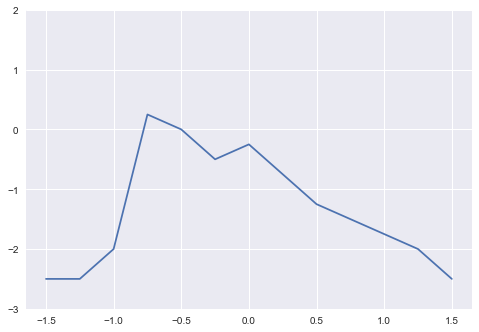

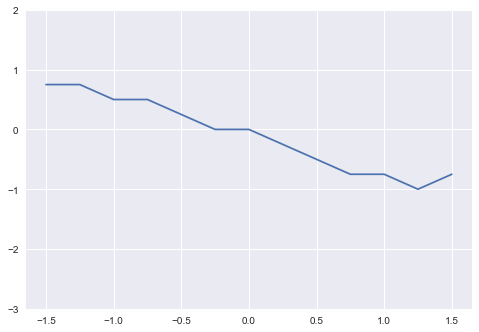

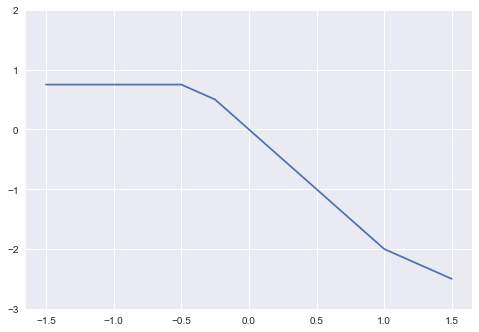

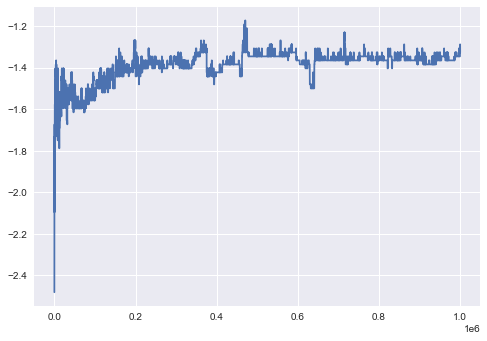

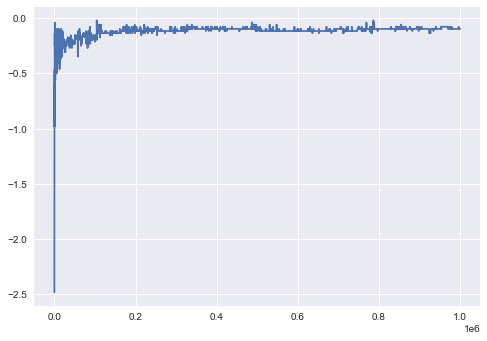

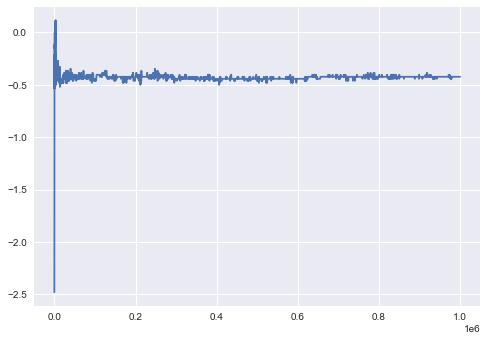

In [81]:
# plot the state distribution evolution for final episode

# plot average learning rate for each episode
for i in range(N_s+1):
    plt.figure(i)
    plt.plot(state_space, action_space[np.argmin(Q[i, :], axis = 1)])
    plt.ylim([-3,2])

# Compared to Analytical Solution

In [ ]:
for i in range(N_s+1):
    plt.figure(i+3)
    plt.plot(range(episodes), actions[:,i])

# Compared to Analytical Solution

# Conclusions and Discussion

- notice that where sa_counter visits most, we have the most accurate results
 - if we were trading, then going against the crowd with this algorithm would have poor results
- notice that np.min returns index of first min it finds if there are multiple. Given that the matrix at the beginning of the episodes is all 0s, it makes sense that action_space[0] = -2.5 is the action of the negative state values at time t = 0
- maybe try larger epsilon for more exploration